In [1]:
%config IPCompleter.greedy=True
%pylab inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

Populating the interactive namespace from numpy and matplotlib


# k-NN Project: Music Genre Prediction

author: andrew.pouret@berkeley.edu, matthieujacquand@berkeley.edu

## Dataset

Dataset : https://www.kaggle.com/carlthome/gtzan-genre-collection 

We've extracted our own features from the original audio file dataset.

![datset-extraction-figure](./docs/DatasetCreation.jpg)

In [2]:
dataset_file = "datasets/datav2.csv"

df = pd.read_csv(dataset_file, sep=",")

# Data Descriptive Statistics

## Summaries and Analysis

Describing the whole dataset by mean, interquartiles, count, standard deviation, min and max values.

In [3]:
df.describe()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,cont5,cont6,cont7,spectram_flatness,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5,tonnetz6
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.380795,0.124698,1883.001208,1865.303842,3878.803772,0.101184,-162.754063,121.255273,-29.199931,54.109434,...,21.068699,25.304243,42.011566,0.001171,0.024199,0.022751,-0.000859,0.007904,0.000739,-0.000483
std,0.082699,0.062342,522.242739,339.144108,1096.400581,0.039370,95.151859,23.111192,20.168244,16.110998,...,3.139612,3.215191,5.889988,0.004498,0.088373,0.087442,0.057218,0.058348,0.016921,0.018316
min,0.171805,0.005014,549.065530,796.514455,710.220705,0.021877,-556.024780,42.361320,-99.755829,-3.247742,...,14.707758,18.454522,14.543139,0.000024,-0.280692,-0.279626,-0.269872,-0.213347,-0.083503,-0.080987
25%,0.321059,0.082679,1461.113254,1643.098517,3034.883732,0.071043,-213.648769,104.958897,-42.612360,45.396466,...,18.899340,22.919356,39.393112,0.000305,-0.027305,-0.028036,-0.033594,-0.025548,-0.007281,-0.010498
50%,0.385390,0.116670,1926.222388,1943.105990,4064.821254,0.097405,-138.674522,118.840340,-30.713336,54.597818,...,20.531552,24.822372,43.530784,0.000709,0.024605,0.019438,0.002340,0.009498,0.001412,-0.001173
75%,0.439446,0.167502,2277.180673,2110.350537,4748.075456,0.128231,-95.242519,135.433762,-17.951447,64.680765,...,22.887252,27.249788,46.144489,0.001278,0.072360,0.067379,0.034760,0.042833,0.010938,0.009652
max,0.667248,0.378549,3369.517356,2611.325445,6268.003765,0.257681,15.127309,197.522858,55.721581,98.046173,...,36.530988,39.303396,51.668599,0.108367,0.372279,0.409506,0.217829,0.243350,0.062162,0.075182


We have continuous numerical features only and very different scales.

We therefore need to scale the data if we use algorithms such as KNN that uses distances.

In [4]:
df.groupby("label").describe()

chroma_stft                                                    \
                count      mean       std       min       25%       50%   
label                                                                     
blues           100.0  0.343227  0.058931  0.233692  0.292326  0.341920   
classical       100.0  0.264589  0.044916  0.176353  0.235109  0.261854   
country         100.0  0.345596  0.041632  0.221800  0.318387  0.349099   
disco           100.0  0.418476  0.047192  0.222056  0.391103  0.420694   
hiphop          100.0  0.456589  0.047641  0.343888  0.426723  0.456683   
jazz            100.0  0.297616  0.054880  0.171805  0.264486  0.286398   
metal           100.0  0.485472  0.052178  0.344913  0.448991  0.485387   
pop             100.0  0.397489  0.056778  0.226208  0.356170  0.402205   
reggae          100.0  0.409579  0.059100  0.273363  0.372328  0.397364   
rock            100.0  0.389316  0.045168  0.259164  0.360462  0.394556   

                                rmse            ...  tonnetz5            \
                75%       max  count      mean  ...       75%       max   
label                                           ...                       
blues      0.390246  0.466403  100.0  0.129791  ...  0.013261  0.055622   
classical  0.284500  0.437762  100.0  0.040913  ...  0.016419  0.062162   
country    0.376250  0.441659  100.0  0.120016  ...  0.009584  0.049251   
disco      0.443128  0.569531  100.0  0.130006  ...  0.007119  0.021533   
hiphop     0.484775  0.587268  100.0  0.169843  ...  0.009774  0.036470   
jazz       0.330663  0.442270  100.0  0.082410  ...  0.010847  0.039304   
metal      0.518324  0.642209  100.0  0.147867  ...  0.009353  0.030740   
pop        0.437702  0.521142  100.0  0.188373  ...  0.012154  0.033913   
reggae     0.448954  0.667248  100.0  0.116101  ...  0.008121  0.031983   
rock       0.420699  0.492719  100.0  0.121665  ...  0.011834  0.051334   

          tonnetz6                                                    \
             count      mean       std       min       25%       50%   
label                                                                  
blues        100.0 -0.005256  0.021755 -0.054507 -0.020389 -0.002999   
classical    100.0 -0.001839  0.027130 -0.080662 -0.016541 -0.004858   
country      100.0  0.000484  0.019410 -0.080987 -0.010229  0.000994   
disco        100.0  0.000458  0.010017 -0.027367 -0.005791 -0.000586   
hiphop       100.0 -0.000937  0.016823 -0.053909 -0.010909 -0.002743   
jazz         100.0 -0.002036  0.016656 -0.067209 -0.011839 -0.000917   
metal        100.0 -0.000988  0.014494 -0.042202 -0.008900 -0.002690   
pop          100.0 -0.000303  0.015600 -0.035486 -0.007798 -0.000045   
reggae       100.0  0.000680  0.016535 -0.044239 -0.011020 -0.001630   
rock         100.0  0.004909  0.018741 -0.045548 -0.005800  0.004199   

                               
                75%       max  
label                          
blues      0.010329  0.039836  
classical  0.011089  0.075182  
country    0.012310  0.063605  
disco      0.006853  0.032002  
hiphop     0.010512  0.037024  
jazz       0.008909  0.029748  
metal      0.007393  0.053150  
pop        0.007836  0.045903  
reggae     0.011713  0.065845  
rock       0.014932  0.063893  

[10 rows x 512 columns]

The dataset has 64 columns and 10 music genres (groups). Since the work presented during Presentation 1, we have been able to further exctract 38 features including spectral flatness and different coefficients.

In terms of the chroma_stft feature we find that metal has the highest mean, interquartiles and median of the groups, and that classical has the lowest ones. Compared to classical and jazz music, the  metal and hiphop genres are a lot more spreadout in terms of chroma_stft (standard deviation), which may have an influence on how well we detect the metal and hiphop genres.


In terms of the mffc20 feature we find that metal has the lowest mean (was the highest mean for chroma_stft) and median of the groups whereas that classical has the highest ones. Blues has the larget standard deviation and pop has the lowest for the mfcc20.


Overall, some genres seem to stick out but it's hard to find a pattern between genres by looking at 64 different features.


D:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\hist.py:342: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


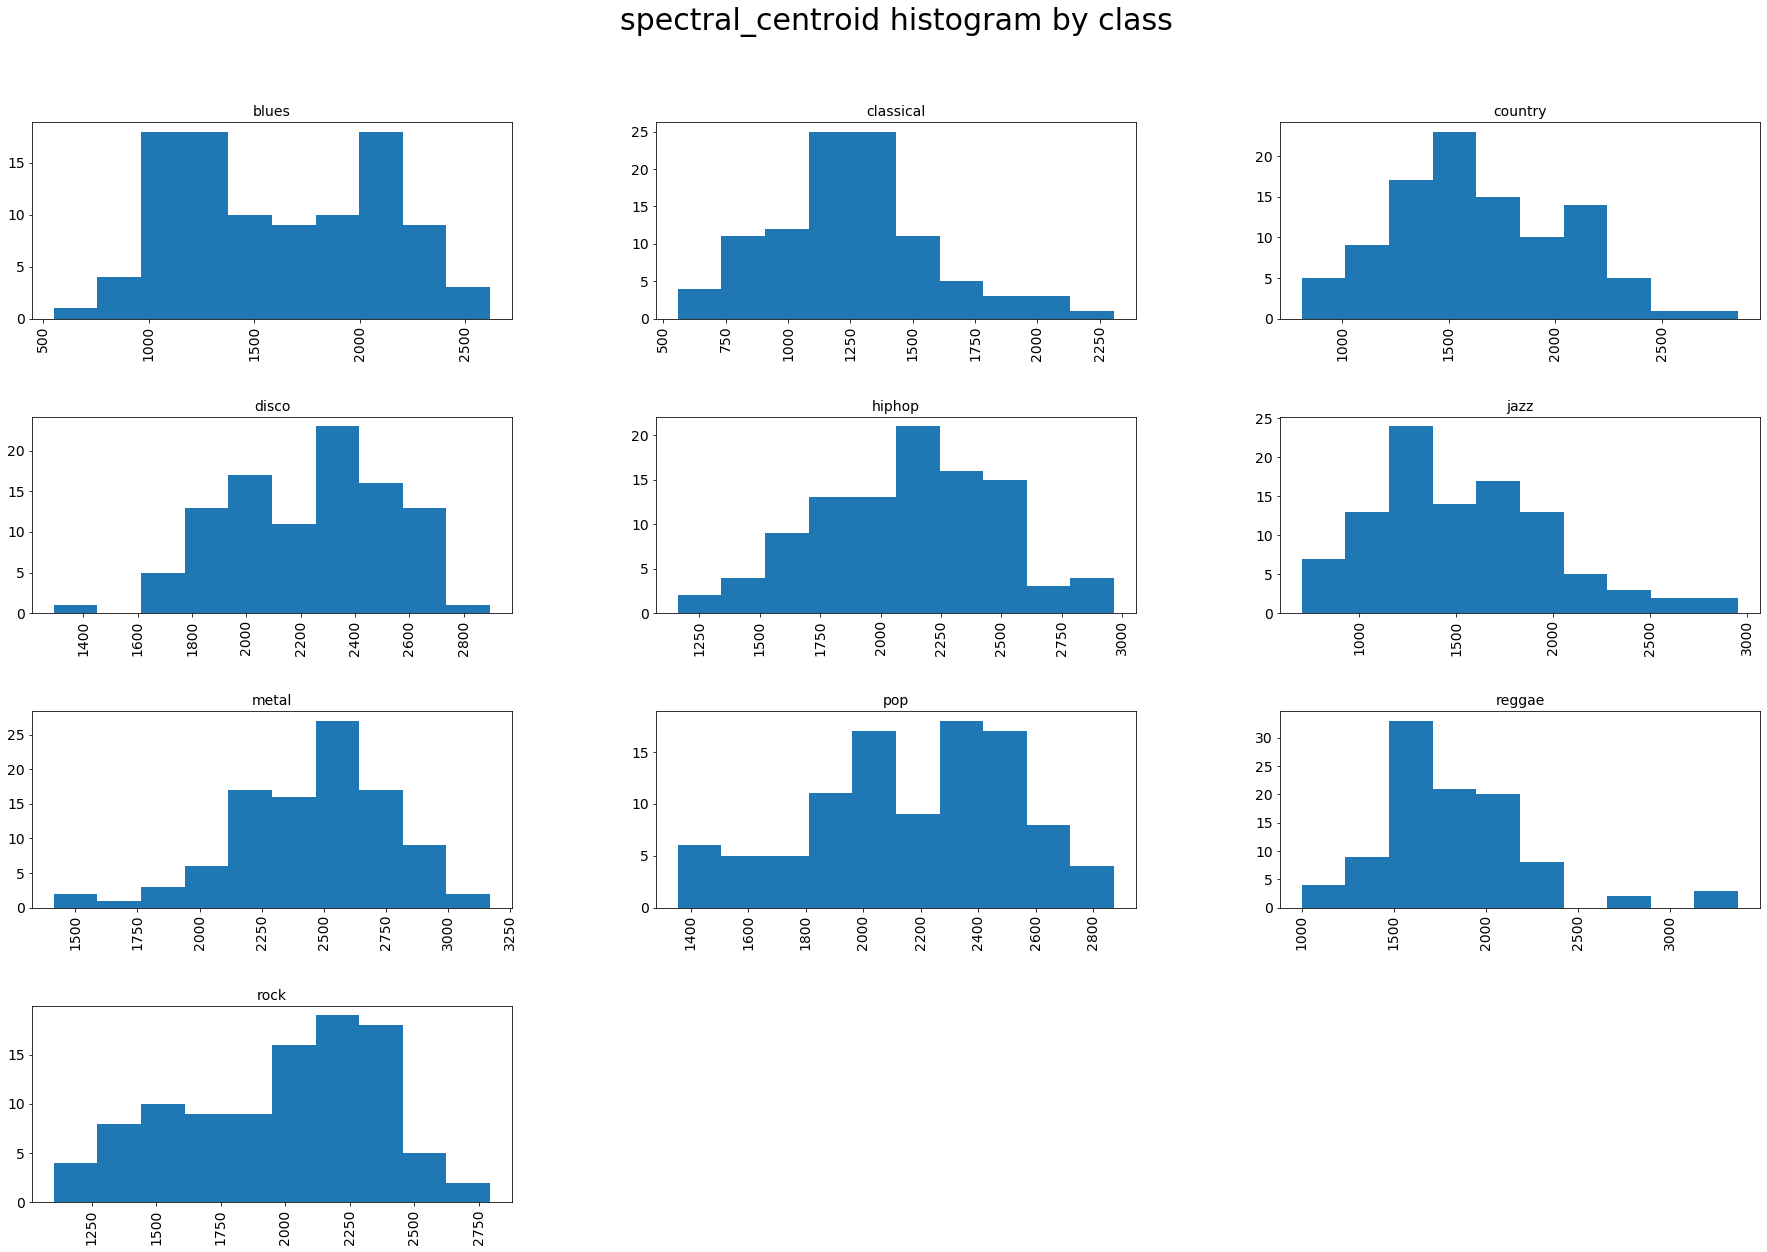

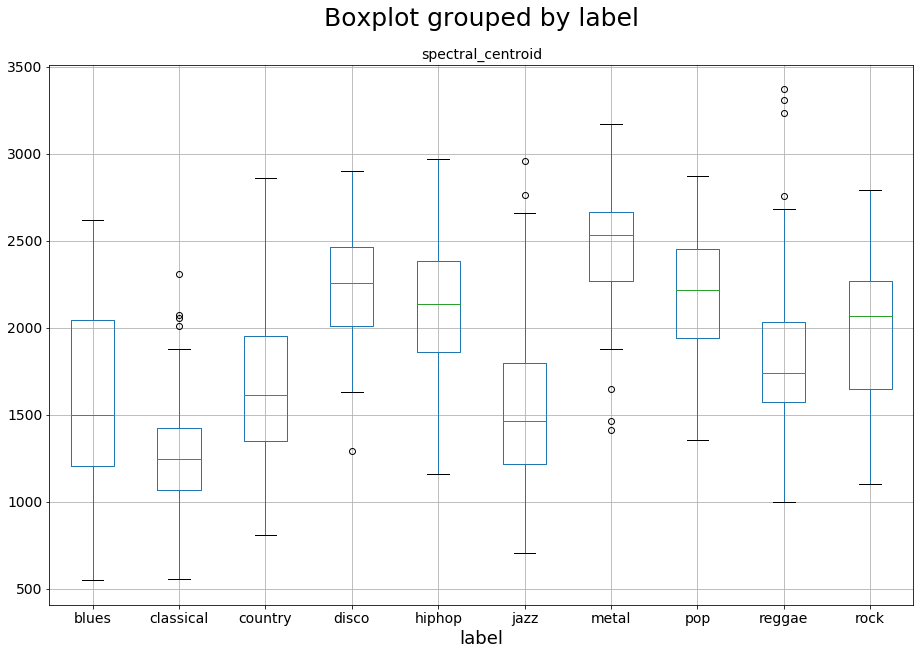

In [5]:
from ml_toolbox import plot_histograms, plot_boxes

plot_histograms(df, "spectral_centroid")
plot_boxes(df, "spectral_centroid")

The range of the Spectral Centroid within a genre is large (a difference of 1000-2000 at least between min and max values of a genre), but 50% of songs within a "genre" are grouped together on a much smaller ranges.

The median for every genre is centered over except for reggae and metal. 

In terms of histogram, some genres like hiphop are, jazz or metal follow a positively or negatively skewed distribution wheras the others don't follow a normal distribution. 

However classical, reggae and metal have a lot of outliers. 

Classical in terms of the spectral centroid has 50% of its invididuals with a lower value than every other genre except (Jazz). Which may have an influence on how well classical music is detected..


We find a strong correlation between features, which is quite logicial since each feature are spectral properties obtained by some signal processing methods that perhaps.

It would be unwise to use a model such as Naive Bayes that requires features to be independant.

# k-NN setup 

As we saw earlier, the dataset features are numerical and continuous.

Our dataset doesn't contain any null values because we've extracted our own features from the audio files.

The scale of the features vary, so we need to scale our dataset before applying our KNN to the dataset.

In [6]:
from sklearn.preprocessing import StandardScaler

X = df.drop(["label", "filename"], axis=1).values

std_scale = StandardScaler().fit(X) # applying feature scaling because KNN uses euclidean distance to ocompute clusters

X = std_scale.transform(X)

y = df["label"].values

# K-NN Implementation

Our goal here is to detect the music genres. Let us go step by step and tailor the best KNN model to support our goal. For now, lets set N (number of neighbors) equal to 3.

### First K-NN - First 11 features - N = 3

In [7]:
#X and Y creation
X = df[['chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2',
                'mfcc3','mfcc4','mfcc5']].values

y = df[['label']].values

#data splitting
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True)

# Data normalization
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
scores = {} # accuracy of scores bewteen model versions

Train set Accuracy: 0.72
Test set Accuracy: 0.54
--- Classification Report ---
              precision    recall  f1-score   support

       blues       0.49      0.81      0.61        21
   classical       0.76      0.95      0.84        20
     country       0.37      0.50      0.43        20
       disco       0.50      0.46      0.48        26
      hiphop       0.36      0.33      0.34        15
        jazz       0.63      0.71      0.67        17
       metal       0.69      0.65      0.67        17
         pop       0.53      0.40      0.46        20
      reggae       0.75      0.43      0.55        21
        rock       0.38      0.22      0.28        23

    accuracy                           0.54       200
   macro avg       0.55      0.55      0.53       200
weighted avg       0.54      0.54      0.53       200



D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class 0: blues
Class 1: classical
Class 2: country
Class 3: disco
Class 4: hiphop
Class 5: jazz
Class 6: metal
Class 7: pop
Class 8: reggae
Class 9: rock


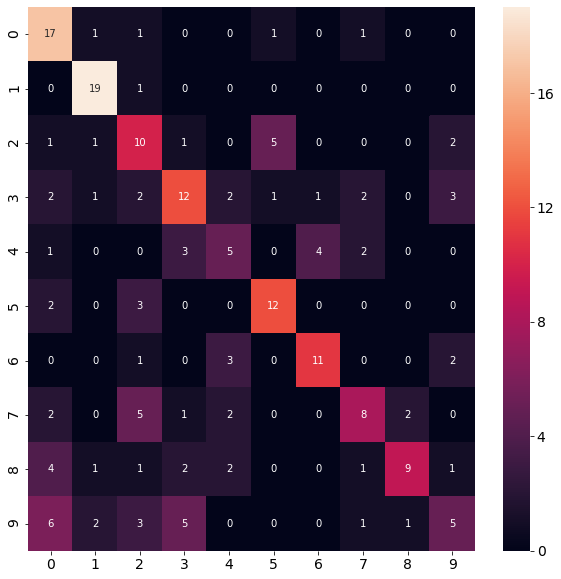

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

from ml_toolbox import show_confusion_matrix

n_neighbors = 3
knn_v0 = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_v0.fit(X_train, y_train.ravel())

train_score = knn_v0.score(X_train, y_train.ravel()) # accuracy

print("Train set Accuracy: %.2f" % train_score)

test_score = knn_v0.score(X_test, y_test.ravel()) # accuracy

print("Test set Accuracy: %.2f" % test_score)

ypred = knn_v0.predict(X_test)

cr = classification_report(y_test, ypred)

print("--- Classification Report ---")
print(cr) 

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

show_confusion_matrix(y_test, ypred, encoder)

The accuracy here for 3 neighbors is very low even on the train set. Let's add some features and see what happens

### Second K-NN - First 24 features - N=3

In [10]:
#X and Y creation
X = df[['chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2',
                'mfcc3','mfcc4','mfcc5','mfcc6','mfcc7','mfcc8','mfcc9','mfcc10','mfcc11','mfcc12','mfcc13','mfcc14','mfcc15','mfcc16',
                'mfcc17','mfcc18','mfcc19','mfcc20']].values 
y = df[['label']].values


#data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True)

# Data normalization
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Train set Accuracy: 0.73
Test set Accuracy: 0.59
--- Classification Report ---
              precision    recall  f1-score   support

       blues       0.46      0.67      0.55        18
   classical       0.73      0.96      0.83        23
     country       0.42      0.57      0.48        14
       disco       0.43      0.48      0.45        25
      hiphop       0.62      0.62      0.62        16
        jazz       0.89      0.67      0.76        24
       metal       0.91      0.59      0.71        17
         pop       0.52      0.67      0.59        18
      reggae       0.77      0.42      0.54        24
        rock       0.44      0.33      0.38        21

    accuracy                           0.59       200
   macro avg       0.62      0.60      0.59       200
weighted avg       0.63      0.59      0.59       200



D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class 0: blues
Class 1: classical
Class 2: country
Class 3: disco
Class 4: hiphop
Class 5: jazz
Class 6: metal
Class 7: pop
Class 8: reggae
Class 9: rock


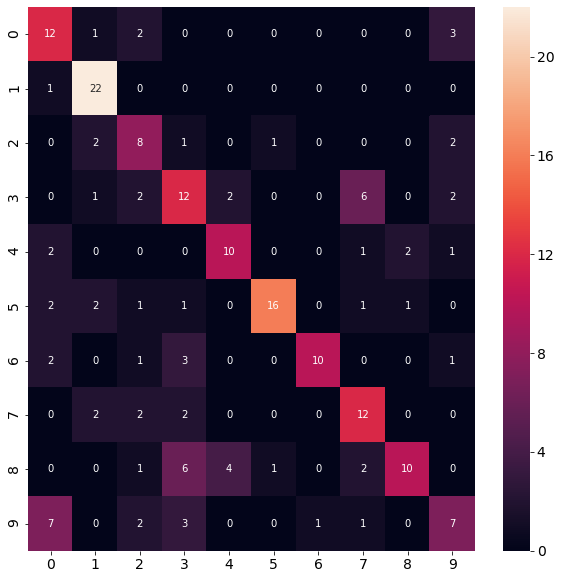

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

from ml_toolbox import show_confusion_matrix

n_neighbors = 3
knn_v1 = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_v1.fit(X_train, y_train.ravel())

train_score = knn_v1.score(X_train, y_train.ravel()) # accuracy

print("Train set Accuracy: %.2f" % train_score)

test_score = knn_v1.score(X_test, y_test.ravel()) # accuracy

print("Test set Accuracy: %.2f" % test_score)


ypred = knn_v1.predict(X_test)

cr = classification_report(y_test, ypred)

print("--- Classification Report ---")
print(cr) 

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

show_confusion_matrix(y_test, ypred, encoder)

By adding 15 features, without changing the number of neighbors, we've increased the accuracy on the test set by 5%. Let us now observe what happens when taking into account all features.

### Third K-NN - 66 features

In [12]:
from sklearn.preprocessing import StandardScaler

X = df.drop(["label", "filename"], axis=1).values


y = df["label"].values

In [13]:
#data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True)

# Data normalization
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Train set Accuracy: 0.76
Test set Accuracy: 0.54
--- Classification Report ---
              precision    recall  f1-score   support

       blues       0.45      0.56      0.50        18
   classical       0.78      0.90      0.84        20
     country       0.38      0.77      0.51        22
       disco       0.27      0.47      0.34        17
      hiphop       0.61      0.46      0.52        24
        jazz       0.79      0.58      0.67        19
       metal       0.75      0.60      0.67        20
         pop       0.58      0.35      0.44        20
      reggae       0.82      0.43      0.56        21
        rock       0.56      0.26      0.36        19

    accuracy                           0.54       200
   macro avg       0.60      0.54      0.54       200
weighted avg       0.60      0.54      0.54       200

Class 0: blues
Class 1: classical
Class 2: country
Class 3: disco
Class 4: hiphop
Class 5: jazz
Class 6: metal
Class 7: pop
Class 8: reggae
Class 9: rock


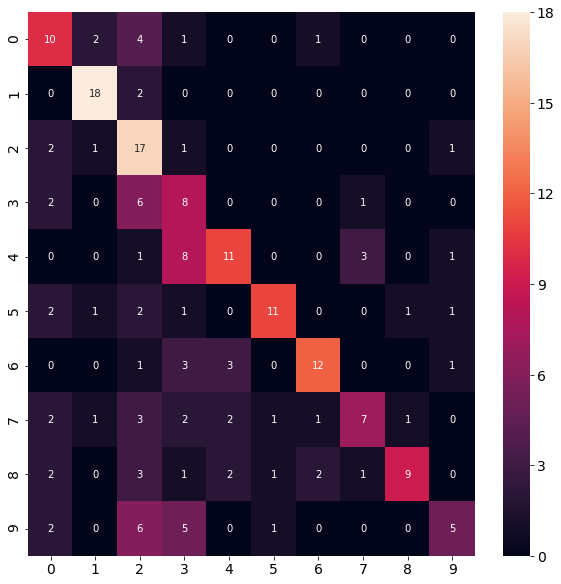

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

from ml_toolbox import show_confusion_matrix

n_neighbors = 3
knn_v1 = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_v1.fit(X_train, y_train.ravel())

train_score = knn_v1.score(X_train, y_train.ravel()) # accuracy

print("Train set Accuracy: %.2f" % train_score)

test_score = knn_v1.score(X_test, y_test.ravel()) # accuracy

print("Test set Accuracy: %.2f" % test_score)


ypred = knn_v1.predict(X_test)

cr = classification_report(y_test, ypred)

print("--- Classification Report ---")
print(cr) 

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

show_confusion_matrix(y_test, ypred, encoder)

Adding extra features at this point doesn't improve precision. Let us figure out which of these features are most important . We also need to figure out which is the best number of neighbors to be applied with the best set of features.

### Fourth K-NN - Finding the best combination between used features AND number of neighbors

Let us begin by using a RandomForestRegressor to class features by importance.

In [15]:
encoder = preprocessing.LabelEncoder()
encoder.fit(y)

y_encoded = encoder.transform(y)

#data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, shuffle = True)

# Data normalization
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



[0.04321498 0.01784772 0.00672302 0.02845987 0.05220043 0.00982025
 0.0129759  0.01588983 0.01999691 0.03520399 0.01759444 0.01696057
 0.01057148 0.02479419 0.0238129  0.00999939 0.0137172  0.0190338
 0.01360942 0.017721   0.01047271 0.00846212 0.01603728 0.01130767
 0.01315286 0.01053896 0.01641547 0.00612001 0.0061623  0.01732188
 0.01100549 0.01627157 0.00925605 0.00588216 0.0075696  0.00733075
 0.01567151 0.01258192 0.0071109  0.00891143 0.00838247 0.01034952
 0.00875554 0.0079005  0.00864688 0.00653106 0.00740637 0.00595064
 0.00886971 0.00988588 0.01835088 0.01407221 0.01334121 0.01499096
 0.06307666 0.02916962 0.00912304 0.07597876 0.007022   0.00738555
 0.0085208  0.01076346 0.00753552 0.01026081]
[33 47 27 28 45  2 58 38 35 59 46 62 34 43 40 21 60 44 42 48 39 56 32  5
 49 15 63 41 20 25 12 61 30 23 37  6 24 52 18 16 51 53 36  7 22 31 26 11
 29 10 19  1 50 17  8 14 13  3 55  9  0  4 54 57]


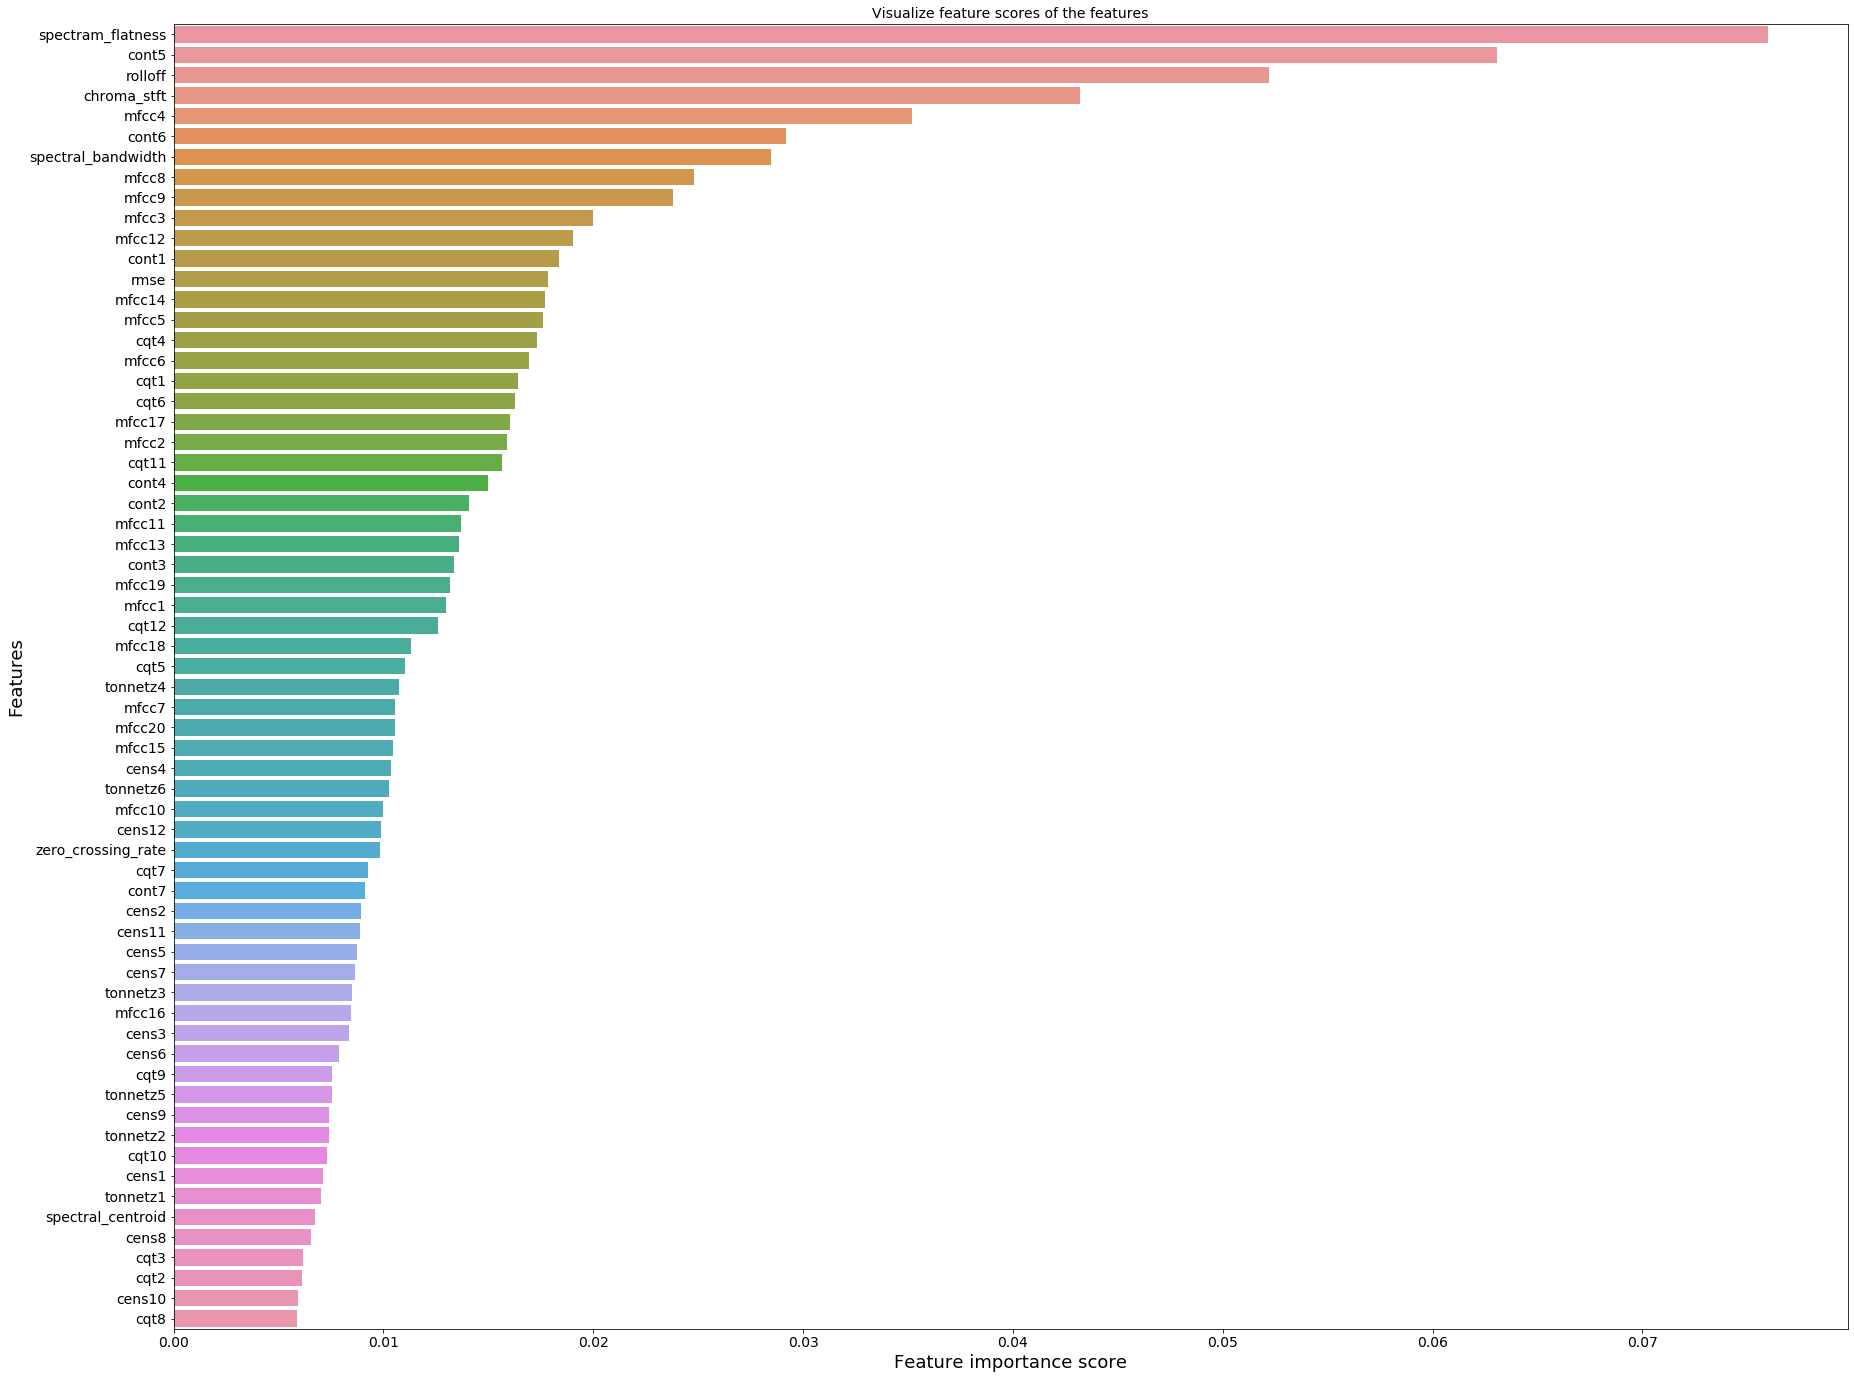

In [16]:
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

rf = RandomForestRegressor(n_estimators=100)

rf.fit(X_train, y_train.ravel())
rf.feature_importances_
print(rf.feature_importances_)
sorted_idx = rf.feature_importances_.argsort()

print(sorted_idx)

# view the feature scores
feature_scores = pd.Series(rf.feature_importances_, index=['chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2',
                'mfcc3','mfcc4','mfcc5','mfcc6','mfcc7','mfcc8','mfcc9','mfcc10','mfcc11','mfcc12','mfcc13','mfcc14','mfcc15','mfcc16',
                'mfcc17','mfcc18','mfcc19','mfcc20', 'cqt1','cqt2','cqt3','cqt4','cqt5','cqt6','cqt7','cqt8','cqt9','cqt10','cqt11','cqt12',
                'cens1','cens2','cens3','cens4','cens5','cens6','cens7','cens8','cens9','cens10','cens11','cens12',
                'cont1','cont2','cont3','cont4','cont5','cont6','cont7','spectram_flatness', 'tonnetz1','tonnetz2','tonnetz3','tonnetz4','tonnetz5','tonnetz6',]).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df.T)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

The `rolloff` , `cont5`,`spectral flatness` and `chroma_stft` seem to be the most important importance to build the random forest trees. 

Let us now run a loop to figure out which is the best number of features used for different values of k (number of neighbors). This combined approach will allow us to have the most efficient combination.

In [26]:
X = df.drop(["label", "filename"], axis=1).values


y = df["label"].values

def findmymodel(X, y, n_neighbors):
    
  

    encoder = preprocessing.LabelEncoder()
    encoder.fit(y)

    y_encoded = encoder.transform(y)

    #data splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, shuffle = True)

    # Data normalization
    scaler = StandardScaler()
    scaler.fit(X)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    knn_v3 = KNeighborsClassifier(n_neighbors)
    
    knn_v3.fit(X_train, y_train.ravel())
    
    train_score = knn_v3.score(X_train, y_train.ravel()) # accuracy
    test_score = knn_v3.score(X_test, y_test.ravel()) # accuracy
    
    return {"train_accuracy": train_score, "test_accuracy": test_score, "number_features": X.shape[1]} 







Number of neighbors :  1
Best score: 0.695, with 34 features


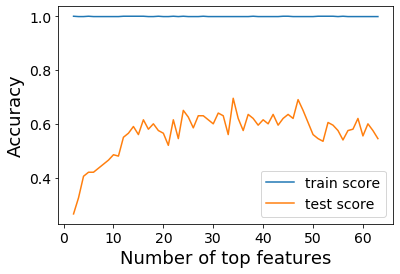

Number of neighbors :  2
Best score: 0.645, with 27 features


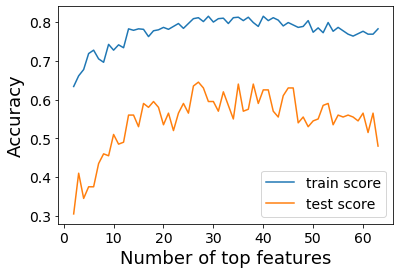

Number of neighbors :  3
Best score: 0.69, with 31 features


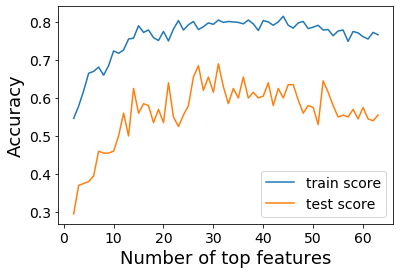

Number of neighbors :  4
Best score: 0.705, with 28 features


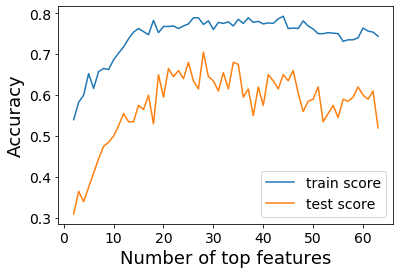

Number of neighbors :  5
Best score: 0.735, with 42 features


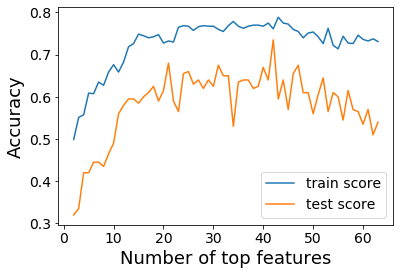

Number of neighbors :  6
Best score: 0.705, with 44 features


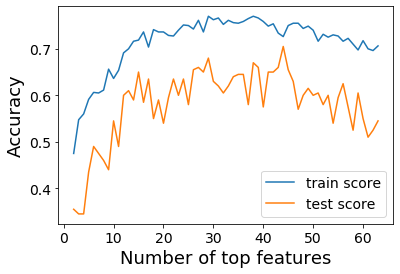

Number of neighbors :  7
Best score: 0.675, with 34 features


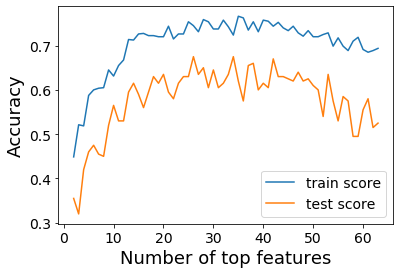

Number of neighbors :  8
Best score: 0.7, with 53 features


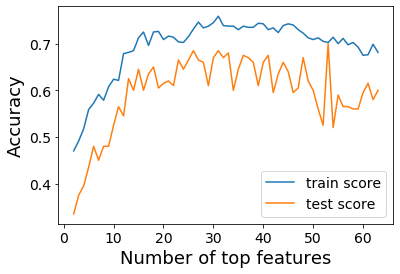

Number of neighbors :  9
Best score: 0.735, with 45 features


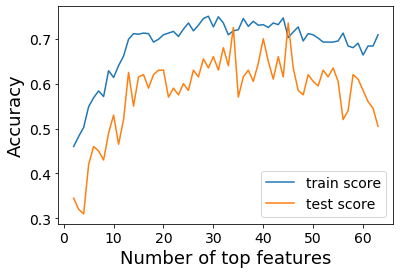

Number of neighbors :  10
Best score: 0.69, with 28 features


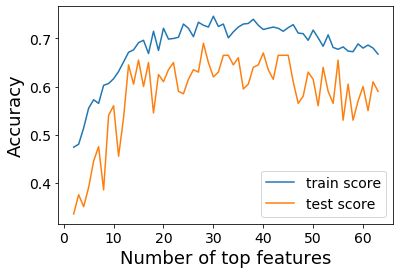

Number of neighbors :  11
Best score: 0.69, with 37 features


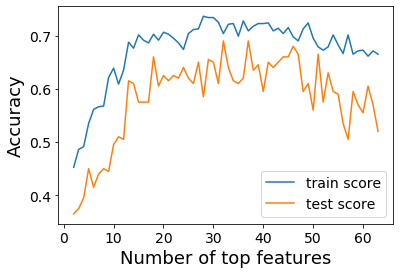

Number of neighbors :  12
Best score: 0.695, with 18 features


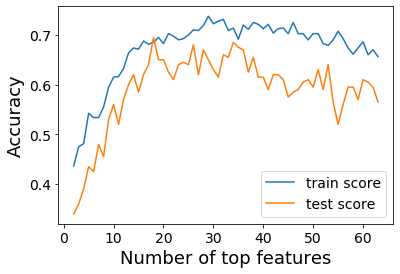

Number of neighbors :  13
Best score: 0.71, with 27 features


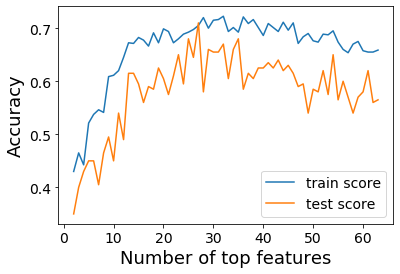

Number of neighbors :  14
Best score: 0.705, with 40 features


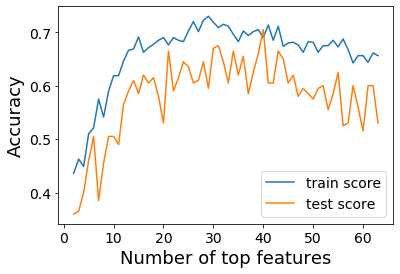

Number of neighbors :  15
Best score: 0.69, with 33 features


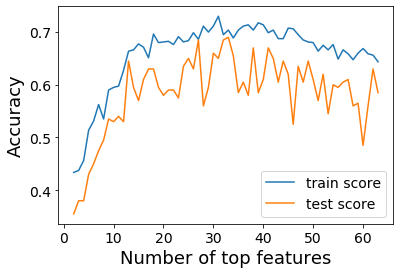

Number of neighbors :  16
Best score: 0.7, with 37 features


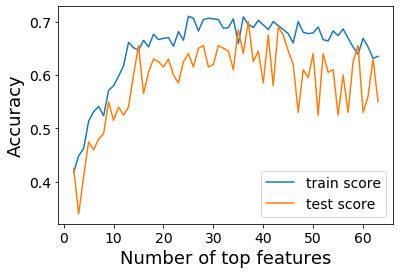

Number of neighbors :  17
Best score: 0.68, with 46 features


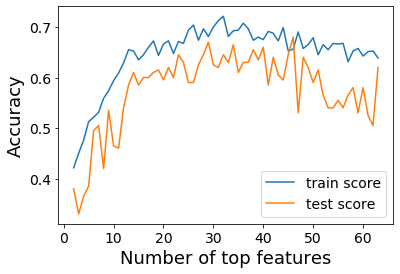

Number of neighbors :  18
Best score: 0.675, with 36 features


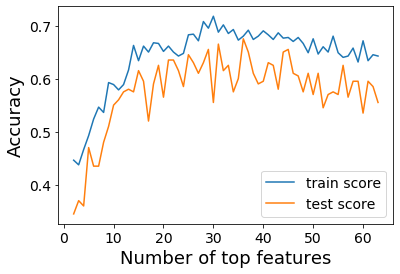

Number of neighbors :  19
Best score: 0.675, with 36 features


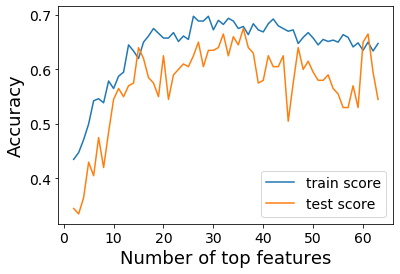

Number of neighbors :  20
Best score: 0.725, with 15 features


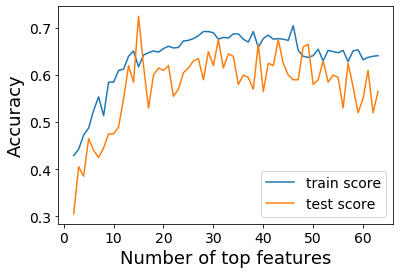

In [27]:
for n_neighbors in range (1,21):
    y = df[['label']].values

    results = []
    features_range = range(2, len(feature_scores.index))
    for i in features_range:
        X = df[list(feature_scores.index)[:i]]
        scores = findmymodel(X, y.ravel(), n_neighbors)
        results.append(scores)
        
    %matplotlib inline

    train_score_results = [r["train_accuracy"] for r in results]
    test_score_results = [r["test_accuracy"] for r in results]
    nb_feature_results = [r["number_features"] for r in results]

    plt.plot(features_range, train_score_results, label="train score")
    plt.plot(features_range, test_score_results, label="test score")



    max_result = max(test_score_results)

    for i in range(len(test_score_results)):
        if test_score_results[i] == max_result:
            best_nb_features = nb_feature_results[i]

    
    print("Number of neighbors : ", n_neighbors)
    print(f"Best score: {max_result}, with {best_nb_features} features")


    plt.xlabel('Number of top features')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Finally we found that the best model is 5-NN trained on 42 features (vs 64 total). Let us see what those 42 features are and recreate the best model.

In [28]:
print(feature_scores.index)
print(feature_scores.index[42])

Index(['spectram_flatness', 'cont5', 'rolloff', 'chroma_stft', 'mfcc4',
       'cont6', 'spectral_bandwidth', 'mfcc8', 'mfcc9', 'mfcc3', 'mfcc12',
       'cont1', 'rmse', 'mfcc14', 'mfcc5', 'cqt4', 'mfcc6', 'cqt1', 'cqt6',
       'mfcc17', 'mfcc2', 'cqt11', 'cont4', 'cont2', 'mfcc11', 'mfcc13',
       'cont3', 'mfcc19', 'mfcc1', 'cqt12', 'mfcc18', 'cqt5', 'tonnetz4',
       'mfcc7', 'mfcc20', 'mfcc15', 'cens4', 'tonnetz6', 'mfcc10', 'cens12',
       'zero_crossing_rate', 'cqt7', 'cont7', 'cens2', 'cens11', 'cens5',
       'cens7', 'tonnetz3', 'mfcc16', 'cens3', 'cens6', 'cqt9', 'tonnetz5',
       'cens9', 'tonnetz2', 'cqt10', 'cens1', 'tonnetz1', 'spectral_centroid',
       'cens8', 'cqt3', 'cqt2', 'cens10', 'cqt8'],
      dtype='object')
cont7


All features up to cont7 excluded are to be kept.

In [43]:
X = df.drop(["label", "filename","cont7", "cens2", "cens11", "cens5",
       "cens7", "tonnetz3", "mfcc16", "cens3", "cens6", "cqt9", "tonnetz5",
       "cens9", "tonnetz2", "cqt10", "cens1", "tonnetz1", "spectral_centroid",
       "cens8", "cqt3", "cqt2", "cens10", "cqt8"], axis=1).values


y = df["label"].values

In [44]:
#data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle = True)

# Data normalization
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Train set Accuracy: 0.76
Test set Accuracy: 0.71
--- Classification Report ---
              precision    recall  f1-score   support

       blues       0.72      0.82      0.77        22
   classical       0.73      0.96      0.83        23
     country       0.37      0.70      0.48        10
       disco       0.50      0.57      0.53        14
      hiphop       0.71      0.65      0.68        23
        jazz       0.86      0.72      0.78        25
       metal       0.94      0.89      0.91        18
         pop       0.68      0.65      0.67        20
      reggae       0.82      0.64      0.72        22
        rock       0.73      0.48      0.58        23

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.70       200
weighted avg       0.73      0.71      0.71       200

Class 0: blues
Class 1: classical
Class 2: country
Class 3: disco
Class 4: hiphop
Class 5: jazz
Class 6: metal
Class 7: pop
Class 8: reggae
Class 9: rock


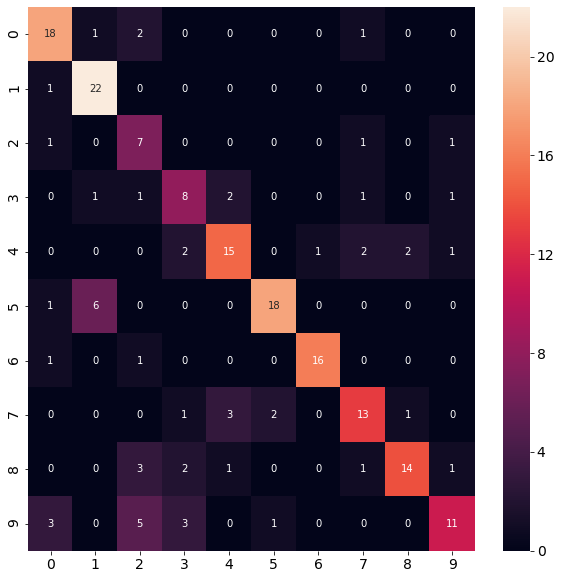

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

from ml_toolbox import show_confusion_matrix

n_neighbors = 5
knn_v4 = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_v4.fit(X_train, y_train.ravel())

train_score = knn_v4.score(X_train, y_train.ravel()) # accuracy

print("Train set Accuracy: %.2f" % train_score)

test_score = knn_v4.score(X_test, y_test.ravel()) # accuracy

print("Test set Accuracy: %.2f" % test_score)


ypred = knn_v4.predict(X_test)

cr = classification_report(y_test, ypred)

print("--- Classification Report ---")
print(cr) 

encoder = preprocessing.LabelEncoder()
encoder.fit(y)

show_confusion_matrix(y_test, ypred, encoder)

The results observed are more precise. The model is really good at identifying metal (0.94), but still struggles with country for instance (0.37). Let us now see if we can further improve this score with dimension reduction.

## Studying the effect of dimension reduction to further improve model score

We will observe the results of two different dimension reduction techniques : PCA (Primary Component Analysis) and NCA (Neighborhood Component Analysis). We will be trying each method for 2 to 2O dimensions and see if we can improve our score.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



encoder = preprocessing.LabelEncoder()
encoder.fit(y)

y = encoder.transform(y)

dim = len(X[0])
n_classes = len(np.unique(y))

n_neighbors = 5
random_state = 0


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, shuffle = True)

# Data normalization
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Nb Dimensions : 2


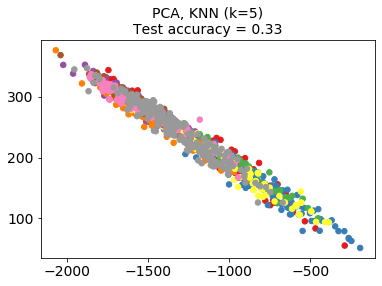

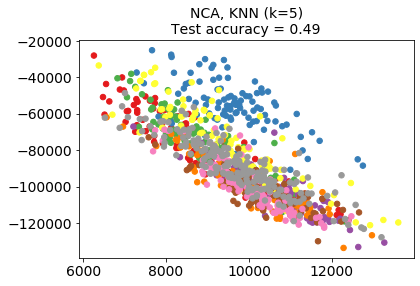

Nb Dimensions : 3


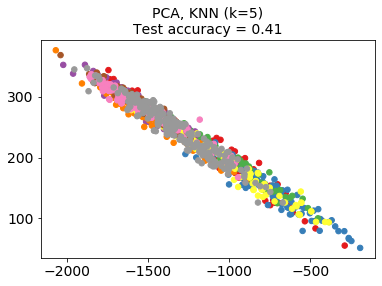

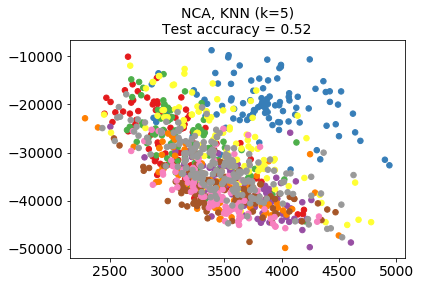

Nb Dimensions : 4


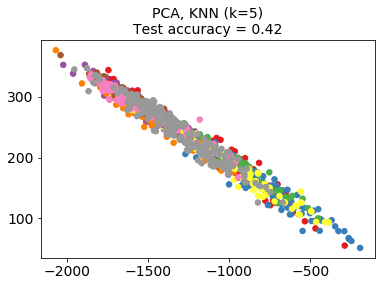

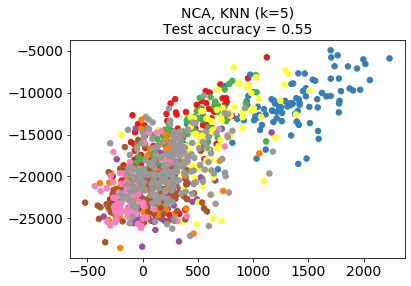

Nb Dimensions : 5


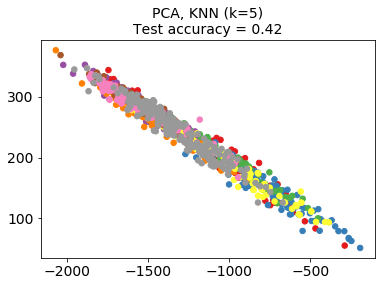

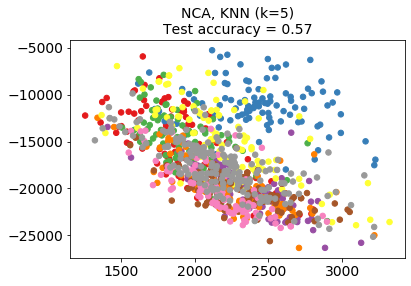

Nb Dimensions : 6


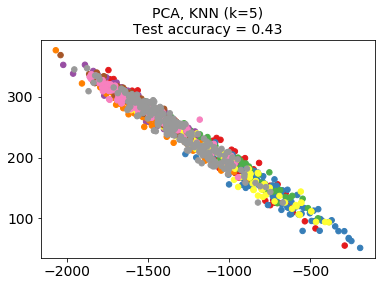

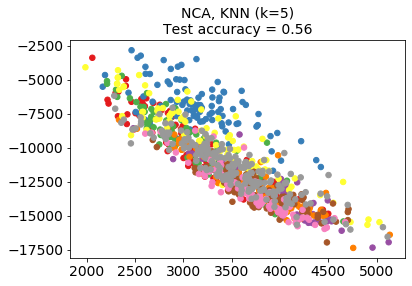

Nb Dimensions : 7


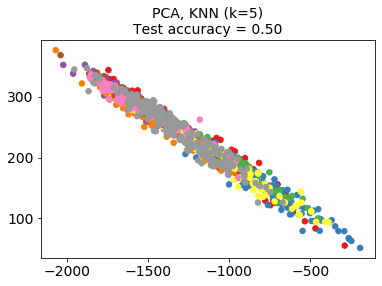

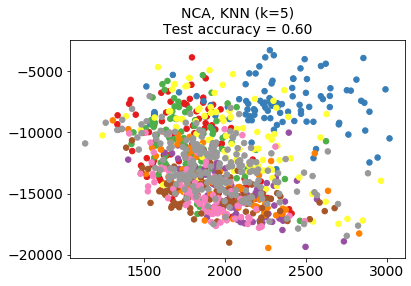

Nb Dimensions : 8


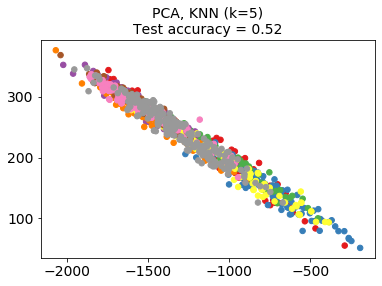

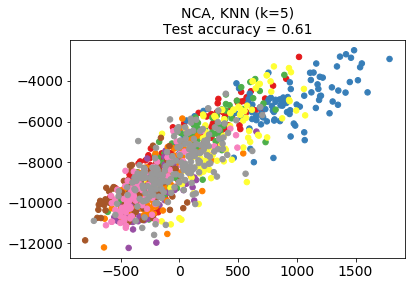

Nb Dimensions : 9


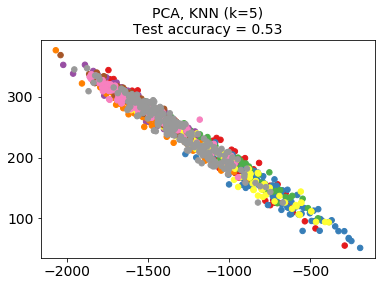

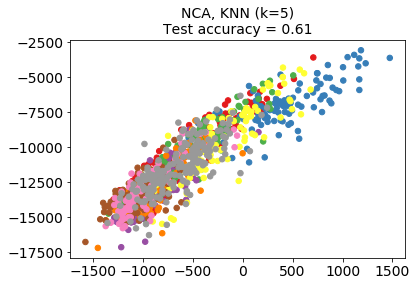

Nb Dimensions : 10


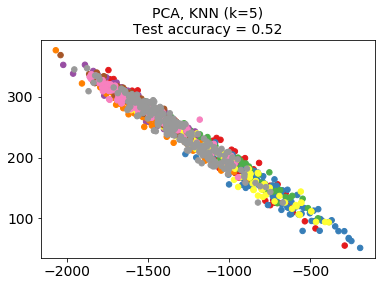

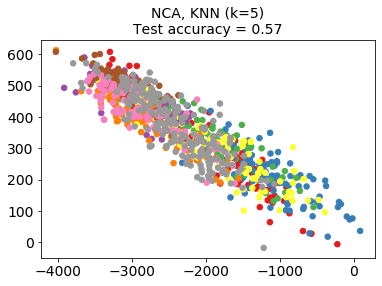

Nb Dimensions : 11


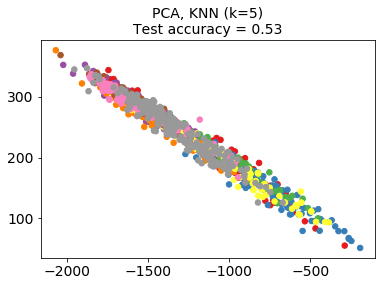

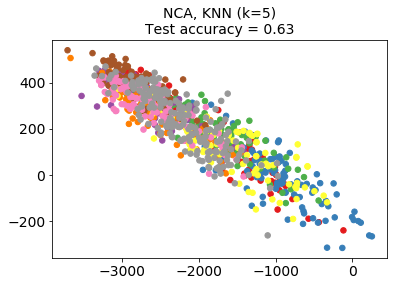

Nb Dimensions : 12


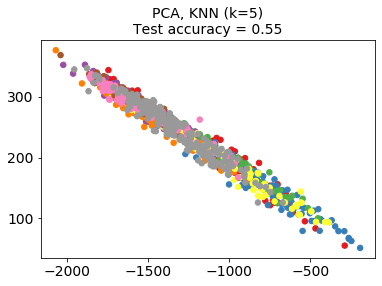

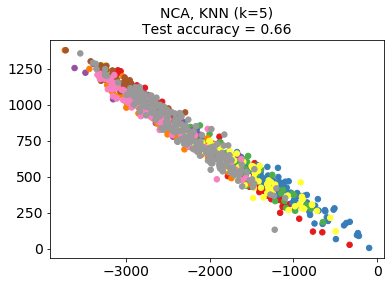

Nb Dimensions : 13


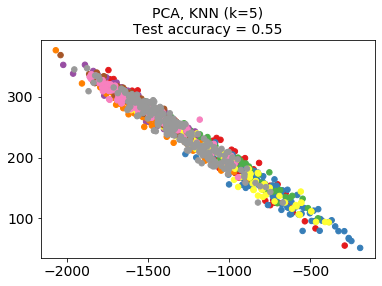

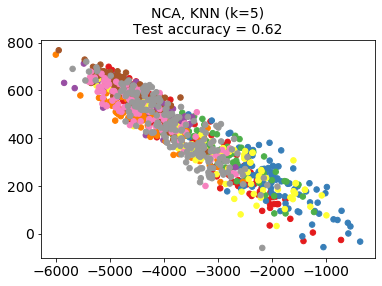

Nb Dimensions : 14


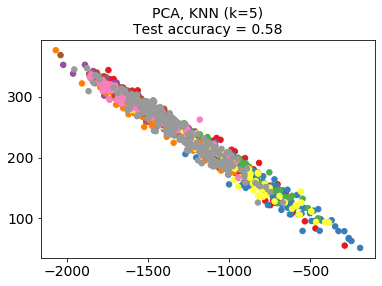

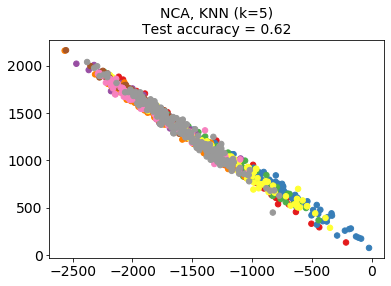

Nb Dimensions : 15


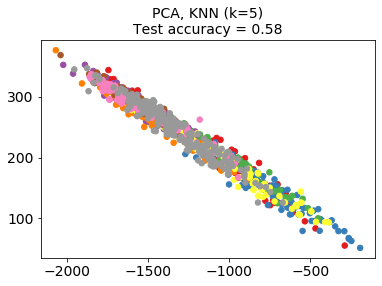

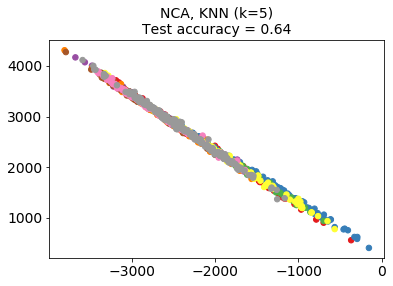

Nb Dimensions : 16


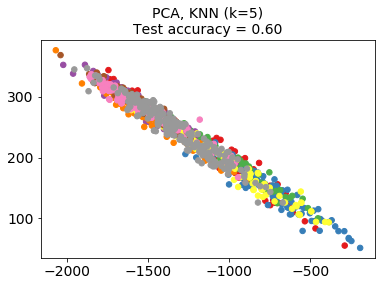

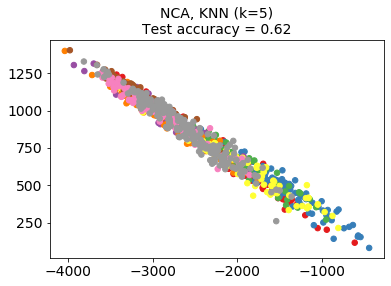

Nb Dimensions : 17


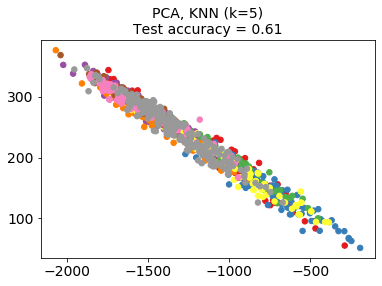

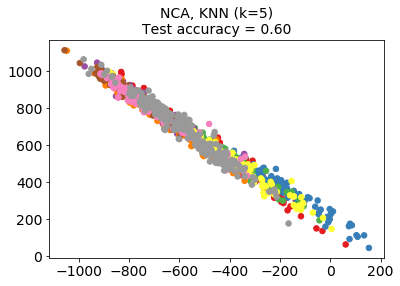

Nb Dimensions : 18


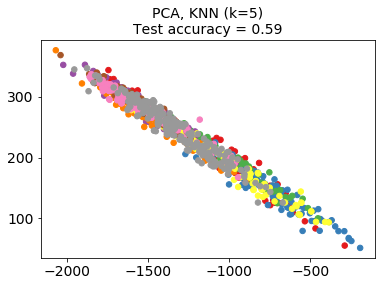

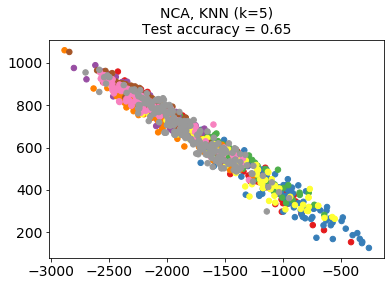

Nb Dimensions : 19


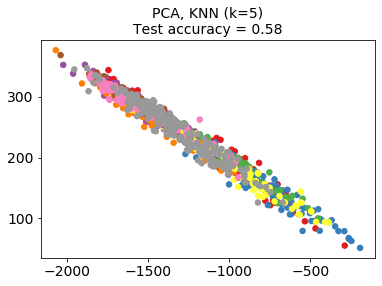

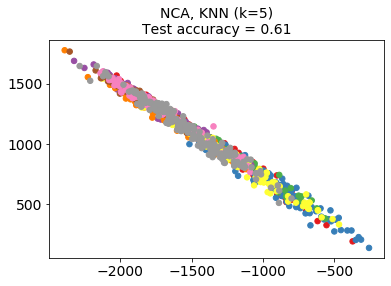

Nb Dimensions : 20


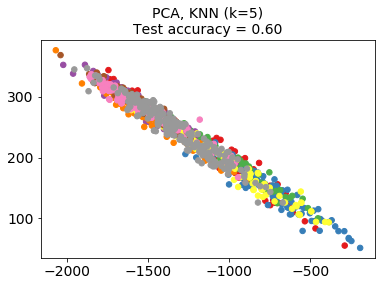

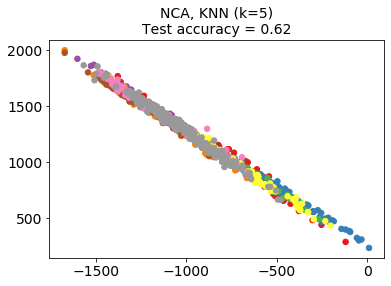

In [48]:
for ncomp in range (2,21) :
    # Reduce dimension to 2 with PCA
    pca = make_pipeline(StandardScaler(),
                        PCA(n_components=ncomp, random_state=random_state))


    # Reduce dimension to 2 with NeighborhoodComponentAnalysis
    nca = make_pipeline(StandardScaler(),
                        NeighborhoodComponentsAnalysis(n_components=ncomp,
                                                       random_state=random_state))

    # Use a nearest neighbor classifier to evaluate the methods
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Make a list of the methods to be compared
    dim_reduction_methods = [('PCA', pca),  ('NCA', nca)]

    # plt.figure()


    for i, (name, model) in enumerate(dim_reduction_methods):
        plt.figure()
        # plt.subplot(1, 3, i + 1, aspect=1)

        # Fit the method's model
        model.fit(X_train, y_train)

        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(model.transform(X_train), y_train)

        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(model.transform(X_test), y_test)

        # Embed the data set in 2 dimensions using the fitted model
        X_embedded = model.transform(X)

        # Plot the projected points and show the evaluation score
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap='Set1')
        plt.title("{}, KNN (k={})\nTest accuracy = {:.2f}".format(name,
                                                                  n_neighbors,
                                                                  acc_knn))
    
    
    print("Nb Dimensions :" , ncomp)
    
    plt.show()

The best score we get is 0.66, which is less than the one obtained with the precedent approach. Dimension reduction is therefore not useful and the best KNN we have been able to create uses 5 nearest neighbors on 42 out of the 64 features of our dataset. Overall, we've achieved a slight improvement in precision with this work.